In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import seaborn as sns
from tensorflow.keras.utils import plot_model
import tensorflow as tf

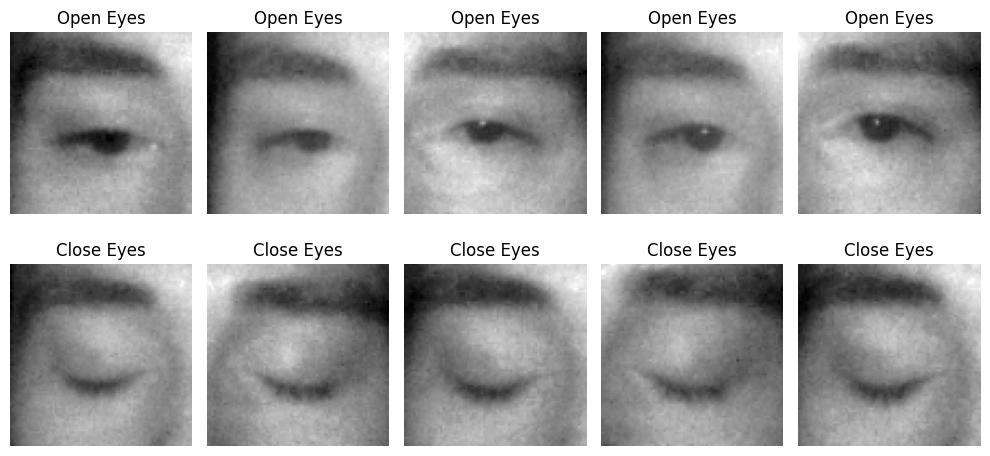

In [2]:
# Define data directories
data_dir = "data/"
open_eye_dir = os.path.join(data_dir, 'Open-Eyes')
close_eye_dir = os.path.join(data_dir, 'Close-Eyes')

# Display some sample images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
open_eye_images = os.listdir(open_eye_dir)[:5]
close_eye_images = os.listdir(close_eye_dir)[:5]

for i, img in enumerate(open_eye_images):
    img_path = os.path.join(open_eye_dir, img)
    axes[0, i].imshow(plt.imread(img_path), cmap='gray')
    axes[0, i].set_title("Open Eyes")
    axes[0, i].axis('off')

for i, img in enumerate(close_eye_images):
    img_path = os.path.join(close_eye_dir, img)
    axes[1, i].imshow(plt.imread(img_path), cmap='gray')
    axes[1, i].set_title("Close Eyes")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [41]:
batch_size = 32
img_size = (64, 64)  # Resize images for uniformity
test_split_ratio = 0.1  # Adjust this to change the test split percentage

# Data generators
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Manually split off part of validation as a test set
total_validation_samples = validation_generator.samples
test_samples = int(total_validation_samples * test_split_ratio)
validation_samples = total_validation_samples - test_samples

# Creating a separate test generator from part of the validation data
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False  # Important for evaluation metrics consistency
)

# Modify validation_generator to only use the remaining validation samples
validation_generator.samples = validation_samples
validation_generator.batch_size = batch_size
validation_generator.reset()

Found 67919 images belonging to 3 classes.
Found 16979 images belonging to 3 classes.
Found 16979 images belonging to 3 classes.


In [42]:
# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

C:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
epochs = 50

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)


Epoch 1/50


C:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2123/2123 ━━━━━━━━━━━━━━━━━━━━ 556s 260ms/step - accuracy: 0.8975 - loss: 0.2429 - val_accuracy: 0.8425 - val_loss: 0.4204
Epoch 2/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 220s 104ms/step - accuracy: 0.9751 - loss: 0.0696 - val_accuracy: 0.9200 - val_loss: 0.1883
Epoch 3/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 55s 26ms/step - accuracy: 0.9815 - loss: 0.0544 - val_accuracy: 0.8994 - val_loss: 0.4047
Epoch 4/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 55s 26ms/step - accuracy: 0.9846 - loss: 0.0439 - val_accuracy: 0.9228 - val_loss: 0.2088
Epoch 5/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 54s 25ms/step - accuracy: 0.9860 - loss: 0.0392 - val_accuracy: 0.9125 - val_loss: 0.2089
Epoch 6/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 54s 25ms/step - accuracy: 0.9871 - loss: 0.0364 - val_accuracy: 0.9144 - val_loss: 0.2384
Epoch 7/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 54s 25ms/step - accuracy: 0.9885 - loss: 0.0333 - val_accuracy: 0.9074 - val_loss: 0.2817
Epoch 8/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 54s 25ms/step - accuracy: 0.9898 - loss: 

In [45]:
import pickle

with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

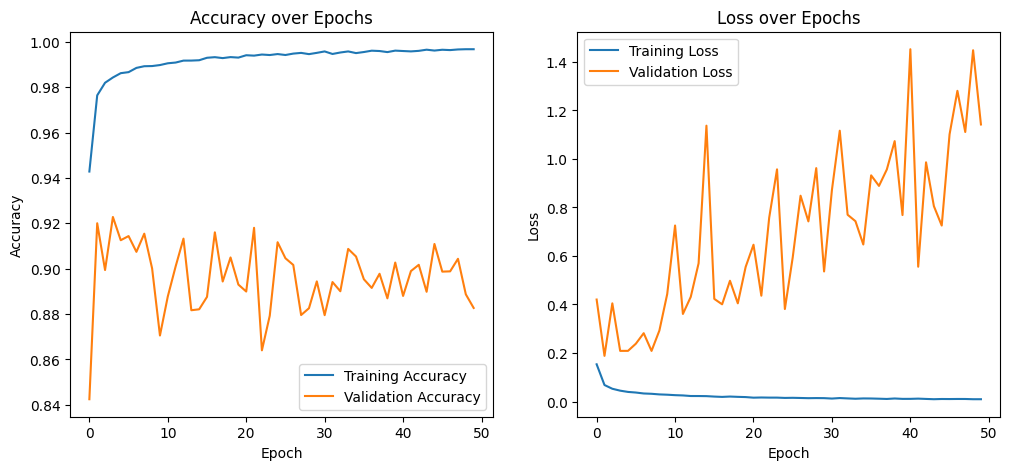

In [46]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [47]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Add test loss and accuracy to history for plotting
history.history['test_loss'] = [test_loss] * epochs
history.history['test_accuracy'] = [test_accuracy] * epochs


 13/531 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9957 - loss: 0.0049   

C:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


531/531 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9309 - loss: 0.7457
Test Loss: 1.1420
Test Accuracy: 0.8827


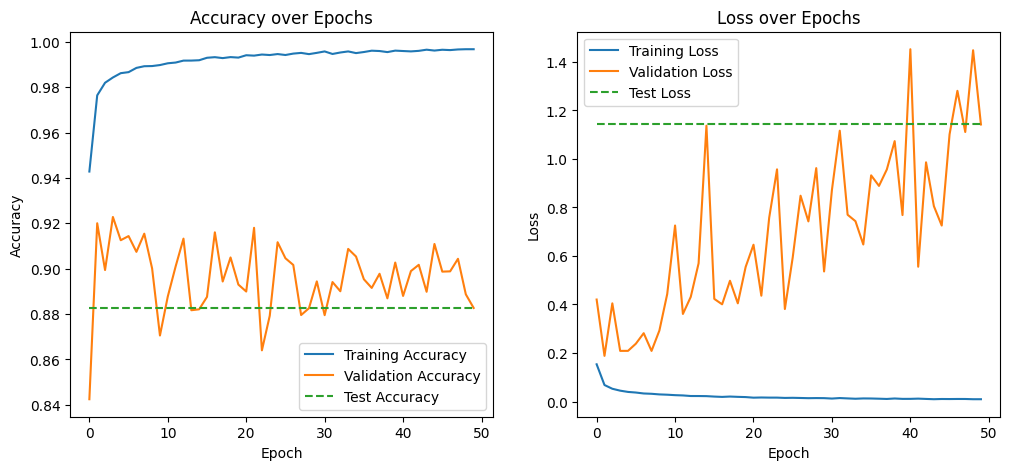

In [48]:
# Plotting accuracy and loss for training, validation, and test
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['test_accuracy'], label='Test Accuracy', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['test_loss'], label='Test Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [49]:
# Generate predictions for the test set
test_generator.reset()
test_predictions = model.predict(test_generator)
test_predictions = (test_predictions > 0.5).astype(int).flatten()  # Binarize predictions

test_pred_labels = (test_predictions > 0.5).astype(int)
# True labels for the test set
test_true_labels = test_generator.classes

# Classification report for test set
print("Test Set Classification Report:")
print(classification_report(test_true_labels, test_predictions, target_names=['Close-Eyes', 'Open-Eyes']))


531/531 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step
Test Set Classification Report:
              precision    recall  f1-score   support

  Close-Eyes       0.85      0.92      0.89      8389
   Open-Eyes       0.91      0.85      0.88      8590

    accuracy                           0.88     16979
   macro avg       0.88      0.88      0.88     16979
weighted avg       0.88      0.88      0.88     16979



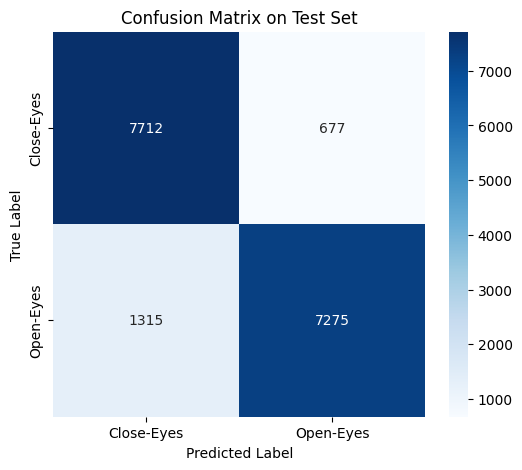

In [50]:
# Confusion matrix for test set
test_cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(test_cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Close-Eyes', 'Open-Eyes'], yticklabels=['Close-Eyes', 'Open-Eyes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

Precision: 0.9149
Recall: 0.8469
F1 Score: 0.8796


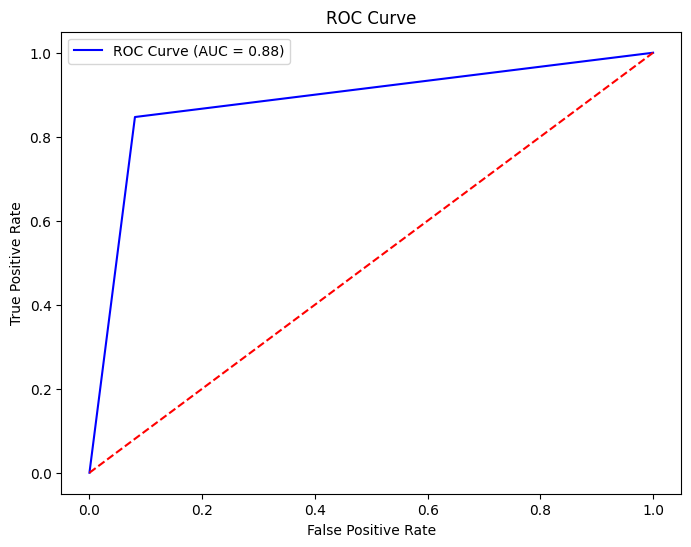

In [51]:

# Calculate precision, recall, and f1-score for test set
precision, recall, f1_score, _ = precision_recall_fscore_support(test_true_labels, test_pred_labels, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(test_true_labels, test_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [52]:
model.save("drowsiness_detection_model_v3.h5")


In [53]:
# Display CNN model architecture
plot_model(model, to_file="cnn_architecture.png", show_shapes=True, show_layer_names=True)
plt.show()

C:\Python311\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


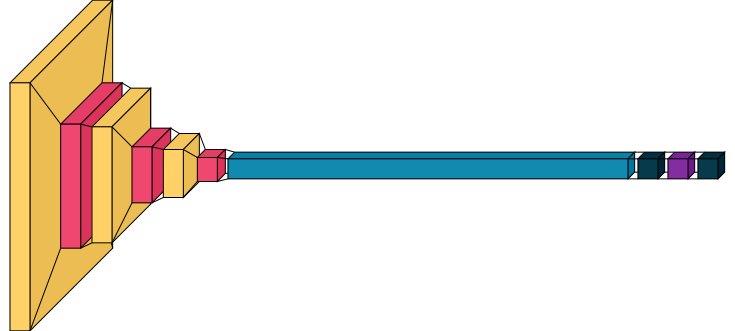

In [54]:
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

In [15]:
import cv2

# Load Haar Cascade for face and eye detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

def get_eye_region(frame):
    # Convert to grayscale for face/eye detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    for (x, y, w, h) in faces:
        face_roi = frame[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(face_roi, 1.1, 4)
        for (ex, ey, ew, eh) in eyes:
            eye_region = face_roi[ey:ey+eh, ex:ex+ew]
            return cv2.resize(eye_region, (64, 64))  # Resize to model's input size
    
    return None


In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import winsound

# Load the trained model
model = load_model("drowsiness_detection_model_v2.h5")

# Define a function to process each frame
def process_frame(frame):
    # Convert to RGB and resize to model's expected input size
    frame_resized = cv2.resize(frame, (64, 64))
    img_array = img_to_array(frame_resized)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array

# Initialize the video capture (0 for the default camera)
cap = cv2.VideoCapture(1)

# Define threshold for drowsiness detection over frames
closed_eye_frames = 0
drowsy_threshold = 5  # Number of consecutive frames with closed eyes to consider drowsy

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale and adjust contrast
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    contrast_img = cv2.equalizeHist(gray)


    # Get the eye region from the frame
    eye_region = get_eye_region(frame)
    if eye_region is not None:
        # Process eye region for prediction
        img_array = img_to_array(eye_region) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)

        if prediction[0][0] < 0.5:
            status = "Drowsy (Eyes Closed)"
            closed_eye_frames += 1
        else:
            status = "Active (Eyes Open)"
            closed_eye_frames = 0

        if closed_eye_frames >= drowsy_threshold:
            alert = "ALERT: Drowsy"
            color = (0, 0, 255)
            winsound.Beep(1000, 500)
        else:
            alert = "Active"
            color = (0, 255, 0)

        # Display results
        cv2.putText(frame, status, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        cv2.putText(frame, alert, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    cv2.imshow("Drowsiness Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



### v3

In [14]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import winsound
from collections import deque

# Load Haar Cascade for face and eye detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Load the trained model
model = load_model("drowsiness_detection_model_v2.h5")

# Parameters for stability
drowsy_threshold = 8  # Number of consecutive frames with closed eyes to consider drowsy
frame_window = 7  # Number of frames to use for averaging predictions
predictions = deque(maxlen=frame_window)  # Store last N predictions

def get_eye_region(frame):
    # Convert to grayscale for face/eye detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    for (x, y, w, h) in faces:
        face_roi = frame[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(face_roi, 1.1, 4)
        for (ex, ey, ew, eh) in eyes:
            eye_region = face_roi[ey:ey+eh, ex:ex+ew]
            return cv2.resize(eye_region, (64, 64))  # Resize to model's input size
    
    return None

# Initialize video capture (0 for default camera)
cap = cv2.VideoCapture(1)

closed_eye_frames = 0  # Counter for consecutive closed-eye frames

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Get the eye region from the frame
    eye_region = get_eye_region(frame)
    if eye_region is not None:
        # Process eye region for prediction
        img_array = img_to_array(eye_region) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)

        # Check if eyes are closed
        if prediction[0][0] < 0.5:
            predictions.append(0)  # 0 for closed eyes
        else:
            predictions.append(1)  # 1 for open eyes

        # Calculate average over frame window
        avg_prediction = sum(predictions) / len(predictions)
        if avg_prediction < 0.5:  # Majority closed eyes
            status = "Drowsy (Eyes Closed)"
            closed_eye_frames += 1
        else:
            status = "Active (Eyes Open)"
            closed_eye_frames = 0

        # Trigger alert if drowsy threshold reached
        if closed_eye_frames >= drowsy_threshold:
            alert = "ALERT: Drowsy"
            color = (0, 0, 255)
            winsound.Beep(1000, 500)  # Beep for alert
        else:
            alert = "Active"
            color = (0, 255, 0)

        # Display results
        cv2.putText(frame, status, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        cv2.putText(frame, alert, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    else:
        status = "Person not in frame"
        alert = "ALERT : Face not detected"
        color = (0, 0, 255)
        winsound.Beep(1000, 500)
        # Display results
        cv2.putText(frame, status, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        cv2.putText(frame, alert, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    cv2.imshow("Drowsiness Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━